### Note :
I have used AI tools only for the purpose of creating github readme files, commenting and debugging at a few stages when I was not able to reach a solution. This code was written by me in its entirety. This file contain the clean code. The code that I created while trying to solve the task is also available in untitled.ipynb

### Note
There were 2553 images in the dataset but the label folder contain 2542 text files so only the images with available labels will be used.

## Importing Data

### Dataset Structure

#### Naming Convention
(dataset, image type, tile identification number, minimum x bound, minimum y bound, and window size)

#### Images
1. The dataset consists of image chips (small cropped satellite images) in .tif format. Each image chip represents a portion of a larger tile.
2. resolution of the image is 416x416 pixel.
#### Labels
1. Each label file contains information about multiple solar panel objects present in the corresponding image chip.
2. Each row of a label file contain (category, x-center, y-center, x-width, y-width).
3. Since these values are normalized, you can convert them back to pixel coordinates using the image size:
- x_center_pixel = x-center × 416 ≈ 85 pixels
- y_center_pixel = y-center × 416 ≈ 319 pixels
- width_pixel = x-width × 416 ≈ 44 pixels
- height_pixel = y-widht × 416 ≈ 44 pixels


In [3]:
### Importing Dependencies
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from sklearn.metrics import auc
import numpy as np
from PIL import Image, ImageDraw
import random
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import os
import yaml
import shutil
import supervision as sv
import torch
import matplotlib.pyplot as plt

In [4]:
# Paths
labels_dir = "data/labels"
image_size = 416  # Since native resolution chips are 416x416

# Create DataFrame
columns = ["image_name","category", "x_center", "y_center", "width", "height", "x_pixel", "y_pixel", "width_pixel", "height_pixel"]
df = pd.DataFrame(columns=columns)

for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        image_name = label_file.replace(".txt", ".tif")
        with open(os.path.join(labels_dir, label_file), "r") as file:
            for line in file:
                category, x_c, y_c, w, h = map(float, line.strip().split())

                # Convert normalized values to pixel values
                x_pixel = int(x_c * image_size)
                y_pixel = int(y_c * image_size)
                width_pixel = int(w * image_size)
                height_pixel = int(h * image_size)

                # Append to DataFrame
                df.loc[len(df)] = [image_name,category, x_c, y_c, w, h, x_pixel, y_pixel, width_pixel, height_pixel]

In [5]:
# Paths
images_dir = "data/image_chips_native"
labels_dir = "data/labels"

def plot_bounding_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_size = 416  # Native resolution size

    with open(label_path, "r") as file:
        for line in file:
            _, x_c, y_c, w, h = map(float, line.strip().split())

            # Convert normalized values to pixel coordinates
            x_pixel = int(x_c * img_size)
            y_pixel = int(y_c * img_size)
            width_pixel = int(w * img_size)
            height_pixel = int(h * img_size)

            # Calculate bounding box coordinates
            x1 = int(x_pixel - width_pixel / 2)
            y1 = int(y_pixel - height_pixel / 2)
            x2 = int(x_pixel + width_pixel / 2)
            y2 = int(y_pixel + height_pixel / 2)

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Display image with bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

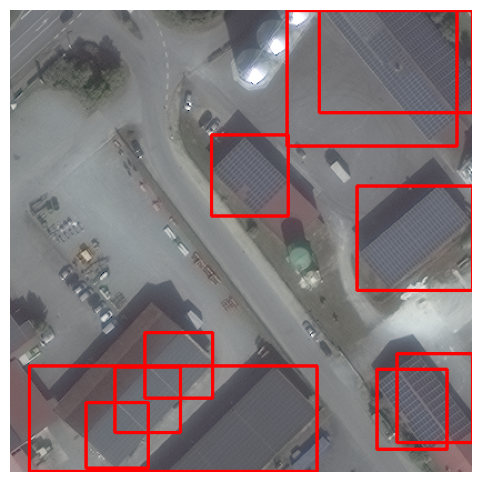

In [6]:
# Visualize one image
sample_image = "solarpanels_native_2__x0_0_y0_11248_dxdy_416.tif"
plot_bounding_boxes(os.path.join(images_dir, sample_image),
                    os.path.join(labels_dir, sample_image.replace(".tif", ".txt")))

Every pixel in the image corresponds to a real world location.
In the Readme_label file it was mentioned that our dataset uses the EPSG:32633 coordinate system, which is UTM Zone 33N. Instead of latitude/longitude, UTM uses meters as units.

- The pixel coordinates may be translated to geocoordinates using the following geotransform for each tile:
- A geotransform is a set of values that tells us how pixel coordinates in an image map to real-world geocoordinates.


`[origin_x ,pixel_width, rotation,origin_y, Rotation, Pixel Height]`

Tile 1: (307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31)
 
Tile 2: (312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31)

Tile 3: (312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)

Our data contain images generated from 3 different tiles which can be found using the name of the image.

We can convert pixel values into geocoordinates using the following transformation:

- x_geo​ =x_origin​ +(x_pixel​ ×pixel_width)
- y_geo​ =y_origin​ +(y_pixel​ ×pixel_height)
- width in meters=(width in pixels)×pixel width
- height in meters=(height in pixels)×pixel height


In [7]:
tile_1 = df[df['image_name'].str.contains('solarpanels_native_1')]
tile_2 = df[df['image_name'].str.contains('solarpanels_native_2')]
tile_3 = df[df['image_name'].str.contains('solarpanels_native_3')]

def pixel_to_geo(x_pixel, y_pixel, width_pixel, height_pixel, geotransform):

    # Convert pixel coordinates to real-world geocoordinates
    x_geo = geotransform[0] + (x_pixel * geotransform[1])
    y_geo = geotransform[3] + (y_pixel * geotransform[5])  # y transformation uses the negative pixel height

    # Convert width and height to meters
    width_meters = width_pixel * geotransform[1]
    height_meters = height_pixel * abs(geotransform[5])  # Use abs() to ensure positive height

    return x_geo, y_geo, width_meters, height_meters

geotransform_tile1 = (307670.04, 0.31, 0.0, 5434427.1, 0.0, -0.31)
geotransform_tile2 = (312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31)
geotransform_tile3 = (312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)
# Example YOLO label values
x_pixel1,y_pixel1,width_pixel1,height_pixel1 = tile_1['x_pixel'],tile_1['y_pixel'],tile_1['width_pixel'],tile_1['height_pixel']
x_pixel2,y_pixel2,width_pixel2,height_pixel2 = tile_2['x_pixel'],tile_2['y_pixel'],tile_2['width_pixel'],tile_2['height_pixel']
x_pixel3,y_pixel3,width_pixel3,height_pixel3 = tile_3['x_pixel'],tile_3['y_pixel'],tile_3['width_pixel'],tile_3['height_pixel']

# Convert
x_geo1, y_geo1, width_meters1, height_meters1 = pixel_to_geo(x_pixel1, y_pixel1, width_pixel1, height_pixel1, geotransform_tile1)
x_geo2, y_geo2, width_meters2, height_meters2 = pixel_to_geo(x_pixel2, y_pixel2, width_pixel2, height_pixel2, geotransform_tile2)
x_geo3, y_geo3, width_meters3, height_meters3 = pixel_to_geo(x_pixel3, y_pixel3, width_pixel3, height_pixel3, geotransform_tile3)

x_geo = pd.concat([x_geo1,x_geo2,x_geo3])
y_geo = pd.concat([y_geo1,y_geo2,y_geo3])
width_meters = pd.concat([width_meters1,width_meters2,width_meters3])
height_meters = pd.concat([height_meters1,height_meters2,height_meters3])

In [8]:
df['x_geo'] = x_geo
df['y_geo'] = y_geo
df['width_meters'] = width_meters
df['height_meters'] = height_meters

In [9]:
df

,image_name,category,x_center,y_center,width,height,x_pixel,y_pixel,width_pixel,height_pixel,x_geo,y_geo,width_meters,height_meters
0,solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif,0.0,0.872596,0.700721,0.057692,0.055288,363,291,24,23,307782.57,5434336.89,7.44,7.13
1,solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif,0.0,0.620192,0.682692,0.043269,0.038462,258,284,18,16,307750.02,5434339.06,5.58,4.96
2,solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif,0.0,0.723558,0.754808,0.052885,0.052885,301,314,22,22,307763.35,5434329.76,6.82,6.82
3,solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif,0.0,0.875000,0.935096,0.028846,0.028846,364,389,12,12,307782.88,5434306.51,3.72,3.72
4,solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif,0.0,0.915865,0.959135,0.043269,0.033654,381,399,18,14,307788.15,5434303.41,5.58,4.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29620,solarpanels_native_3__x0_9990_y0_9864_dxdy_416...,0.0,0.492788,0.853365,0.230769,0.293269,205,355,96,122,312812.63,5363210.49,29.76,37.82
29621,solarpanels_native_3__x0_9990_y0_9864_dxdy_416...,0.0,0.354567,0.878606,0.151442,0.204327,147,365,63,85,312794.65,5363207.39,19.53,26.35
29622,solarpanels_native_3__x0_9990_y0_9864_dxdy_416...,0.0,0.435096,0.878606,0.225962,0.242788,181,365,94,101,312805.19,5363207.39,29.14,31.31
29623,solarpanels_native_3__x0_9990_y0_9864_dxdy_416...,0.0,0.646635,0.774038,0.216346,0.307692,269,322,90,128,312832.47,5363220.72,27.90,39.68


In [10]:
df.to_csv("data/processed_data/converted_labels.csv", index=False)

## Data Exploration and Understanding

In [11]:
df = pd.read_csv("data/processed_data/converted_labels.csv")

### Dataset statistics 
#### 1. How many instances of solar panels are present in the dataset?


In [12]:
## Each row in dataset corresponds to 1 solar panel
print("Number of solar panels in dataset: ", len(df))

Number of solar panels in dataset:  29625


#### 2. Compute and show the value counts of labels per image

In [13]:
labels_per_image = df['image_name'].value_counts()

label_distribution = labels_per_image.value_counts()
pd.DataFrame({"No_of_images":label_distribution.index,"labels":label_distribution.values})

,No_of_images,labels
0,3,221
1,4,218
2,5,217
3,6,189
4,8,184
...,...,...
69,55,1
70,64,1
71,22,1
72,61,1


### Calculate the statistics of the area of solar panels in meters

#### 1. What method was used to compute the area (in meters) for a single instance?

Ans. Since we have already calculated the geo-coordinates we can multiply the widht and height of the bounding box to get an estimate of area in meter

In [14]:
### TO calculate the area we will need to use the geo-coordinates
print("total Area : ",sum(df['width_meters']*df['height_meters']))

total Area :  5673715.650499898


#### 2. What is the mean area and standard deviation?


In [15]:
Area = df['width_meters']*df['height_meters']
print('mean area: ',np.mean(Area))
print('standard deviation of area: ',np.std(Area))

mean area:  191.5178278649789
standard deviation of area:  630.7003355500086


#### 3. Plot the histogram of areas. What do you observe?

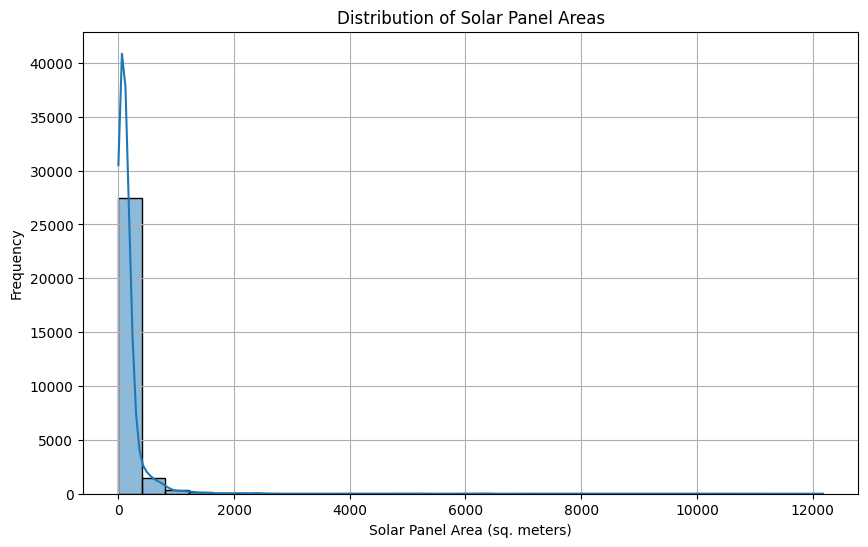

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(Area, bins=30, kde=True)

plt.xlabel("Solar Panel Area (sq. meters)")
plt.ylabel("Frequency")
plt.title("Distribution of Solar Panel Areas")
plt.grid(True)
plt.show()

In [17]:
# Compute histogram bin edges and counts
counts, bin_edges = np.histogram(Area, bins=30)

# Compute bin size (width of each bin)
bin_size = bin_edges[1] - bin_edges[0]

print(f"Bin size: {bin_size} square meters")

27432/len(df)

Bin size: 405.87834999999995 square meters


0.9259746835443038

We can say that majrity of th e solar panels (92.6%) have area less than 407 m^2

## Implementing the Fundamental Functions

#### 1. Write a function to compute IoU (Intersection over Union)
 between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library 


 From the provided blog
- Intersection over Union is an evaluation metric used to measure the accuracy of an object detector.
- in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:

    -  The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
    - The predicted bounding boxes from our model.
    
- IoU=  Area of Union/Area of Intersection
​


In [18]:
## https://shapely.readthedocs.io/en/2.0.6/manual.html#object.union
## https://shapely.readthedocs.io/en/2.0.6/manual.html#object.area

## After converting the bounding box into shapely object we can use the union 
## intersection and area methodmethod to calculate the area of the union of the two bounding boxes

def yolo_to_bbox(yolo_box):
        x_c, y_c, w, h = yolo_box

        x_min = x_c - w / 2
        y_min = y_c - h / 2
        x_max = x_c + w / 2
        y_max = y_c + h / 2
        return x_min, y_min, x_max, y_max
    
def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = yolo_to_bbox(box1)
    x2_min, y2_min, x2_max, y2_max = yolo_to_bbox(box2)

    bbox1 = box(x1_min, y1_min, x1_max, y1_max)
    bbox2 = box(x2_min, y2_min, x2_max, y2_max)

    intersection_area = bbox1.intersection(bbox2).area
    union_area = bbox1.union(bbox2).area

    iou = intersection_area / union_area 
    return iou


box1 = (363,291,24,23) 
box2 = (367,289,20,20) 

iou_value = compute_iou(box1, box2)
print(f"IoU from custom function: {iou_value}")


## https://supervision.roboflow.com/detection/utils/#supervision.detection.utils.box_iou_batch
from supervision.detection.utils import box_iou_batch

## Take a batch of bounding box as input
bbox1 = np.array([yolo_to_bbox(box1)])
bbox2 = np.array([yolo_to_bbox(box2)])
print(f"IoU from Supervision library : {box_iou_batch(bbox1, bbox2)}")

IoU from custom function: 0.5840266222961731
IoU from Supervision library : [[    0.58403]]


#### 2. Write a function to compute Average Precision (AP) 

- True positive and True negative are calculated based on the IoU threshold.
- AP is the area under the precision-recall curve.
- We require precision, recall, IoU and AUC to calculate AP. 

Reference to solve this:
- https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/

In [33]:
# Function to compute IoU using Shapely
def compute_iou(gt_box, pred_box):
    iou = box_iou_batch(np.array(gt_box), np.array(pred_box))
    ans = []
    for i in iou:
        ans.append(max(i))
    return np.array(ans)


def get_precision_and_recall(iou, conf_scores, iou_threshold = 0.5):
    
    sorted_idx = np.argsort(conf_scores)[::-1]  ## Sort the index in descending order
    tp = [iou >= iou_threshold][0].astype(int)
    tp = [tp[i] for i in sorted_idx]
    fp = [iou < iou_threshold][0].astype(int)
    fp = [fp[i] for i in sorted_idx]
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / len(cum_tp)
    
    return precision, recall

def VOC_11(recall, precision):
    recal_11 = np.linspace(0, 1, 11)
    precision_11 = np.zeros(11)
    for i, r in enumerate(recal_11):
        
        precision_11[i] = max(precision[recall >= r] if len(precision[recall >=r]) > 0 else [0])
    
    average_precision = np.mean(precision_11)
    return average_precision

def COCO_101(recall, precision):
    recal_11 = np.linspace(0, 1, 101)
    precision_11 = np.zeros(101)
    for i, r in enumerate(recal_11):
        
        precision_11[i] = max(precision[recall >= r] if len(precision[recall >=r]) > 0 else [0])
    
    average_precision = np.mean(precision_11)
    return average_precision

def AUC(recall, precision):
    return auc(recall, precision)


In [34]:
def generate_random_bbox(img_size, box_size=20):
    """Generate a random bounding box with fixed size"""
    x1 = random.randint(0, img_size - box_size)
    y1 = random.randint(0, img_size - box_size)
    
    return [x1, y1, x1 + box_size, y1 + box_size]

def calculate_iou(box1, box2):
    """Calculate IoU between two bounding boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

def generate_predicted_bbox(gt_bbox, target_iou_range=(0.4, 0.8), max_attempts=1000, box_size=20):
    """Generate a predicted bbox with IoU in the desired range"""
    img_size = 100
    for _ in range(max_attempts):
        pred_bbox = generate_random_bbox(img_size, box_size)
        iou = calculate_iou(gt_bbox, pred_bbox)
        
        if target_iou_range[0] <= iou <= target_iou_range[1]:
            return pred_bbox, iou
    
    return None, None

def create_random_image_with_boxes(img_size=100, box_size=20, save_path=None):
    """Create a random image with ground truth and predicted bounding boxes"""
    # Create random image
    image = Image.new('RGB', (img_size, img_size))
    pixels = np.random.randint(0, 255, (img_size, img_size, 3), dtype=np.uint8)
    image = Image.fromarray(pixels)
    
    # Generate ground truth bbox
    gt_bbox = generate_random_bbox(img_size, box_size)
    
    # Generate predicted bbox with desired IoU
    pred_bbox, iou = generate_predicted_bbox(gt_bbox, box_size=box_size)
    
    if pred_bbox is None:
        return None, None, None, None
    
    # Draw bounding boxes
    draw = ImageDraw.Draw(image)
    
    # Draw ground truth bbox in green
    draw.rectangle(gt_bbox, outline='green', width=2)
    
    # Draw predicted bbox in red
    draw.rectangle(pred_bbox, outline='red', width=2)
    
    if save_path:
        image.save(save_path)
    
    return image, gt_bbox, pred_bbox, iou

def generate_dataset(num_images, box_size=20, output_dir="generated_images"):
    """Generate multiple images with bounding boxes"""
    os.makedirs(output_dir, exist_ok=True)
    
    results = []
    for i in range(num_images):
        image, gt_bbox, pred_bbox, iou = create_random_image_with_boxes(
            box_size=box_size,
            save_path=f"{output_dir}/image_{i}.png"
        )
        
        if image is not None:
            results.append({
                'image_id': i,
                'ground_truth_bbox': gt_bbox,
                'predicted_bbox': pred_bbox,
                'iou': iou
            })
    
    return results


num_images = 10
box_size = 20  # Fixed box size of 20x20
results = generate_dataset(num_images, box_size)

ground_truth_bb = [results[i]['ground_truth_bbox'] for i in range(len(results))]
predicted_bb = [results[i]['predicted_bbox'] for i in range(len(results))]

Average Precision (VOC 11 points): 0.41287878787878785
Average Precision (COCO 101 points): 0.41996699669966986
 Average Precision (AUC): 0.2745039682539682


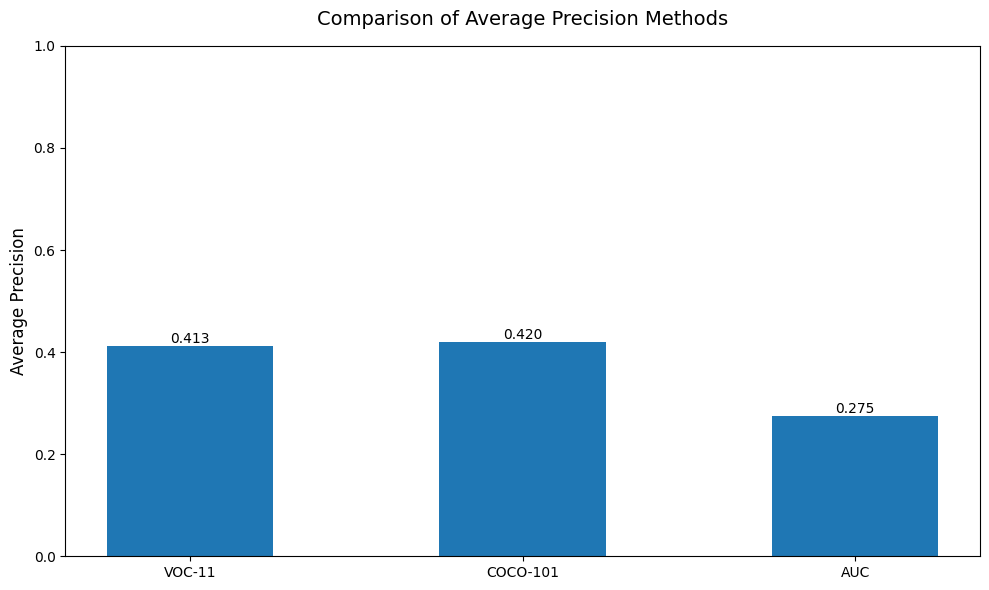

In [35]:
iou = compute_iou(ground_truth_bb, predicted_bb)
np.random.seed(0)
conf_scores = np.random.rand(10)
precision, recall = get_precision_and_recall(iou, conf_scores, iou_threshold = 0.5)
print("Average Precision (VOC 11 points):", VOC_11(recall, precision))
print("Average Precision (COCO 101 points):", COCO_101(recall, precision))
print(" Average Precision (AUC):", AUC(recall, precision))
##############################################################################################################
methods = ['VOC-11', 'COCO-101', 'AUC']
ap_values = [VOC_11(recall, precision), COCO_101(recall, precision), AUC(recall, precision)]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, ap_values, width=0.5)

plt.title('Comparison of Average Precision Methods', fontsize=14, pad=15)
plt.ylabel('Average Precision', fontsize=12)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')
plt.tight_layout()
plt.show()


## Model building and evaluation 

#### 1. Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged. 

In [36]:
df = pd.read_csv("data/processed_data/converted_labels.csv")
df['label_path'] = df['image_name'].str.replace(".tif", ".txt")
df = df[['image_name', 'label_path', 'category']]
df = df.groupby('image_name').first().reset_index()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify=df['category'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42,stratify=train_df['category'])

print(train_df['category'].value_counts())
print(val_df['category'].value_counts())
print(test_df['category'].value_counts())

os.makedirs("data/yolo_data", exist_ok=True)
os.makedirs("datasets/images/train", exist_ok=True)
os.makedirs("datasets/images/val", exist_ok=True)
os.makedirs("datasets/images/test", exist_ok=True)
os.makedirs("datasets/labels/train", exist_ok=True)
os.makedirs("datasets/labels/val", exist_ok=True)
os.makedirs("datasets/labels/test", exist_ok=True)

# Create YOLO dataset structure
splits = {
    'train': train_df['image_name'].tolist(),
    'val': val_df['image_name'].tolist(),
    'test': test_df['image_name'].tolist()
}

for split, images in splits.items():
    for img_name in images:
        # Copy image to appropriate directory
        src_img = os.path.join("data/image_chips_native", img_name)
        dst_img = f"datasets/images/{split}/{img_name}"
        shutil.copy2(src_img, dst_img)  # Using shutil.copy2 to preserve metadata
        
        # Create label file
        src_label = os.path.join("data/labels", img_name.replace(".tif", ".txt"))
        dst_label = f"datasets/labels/{split}/{img_name.replace('.tif', '.txt')}"
        shutil.copy2(src_label, dst_label)

category
0.0    1779
2.0      40
1.0      10
Name: count, dtype: int64
category
0.0    198
2.0      5
1.0      1
Name: count, dtype: int64
category
0.0    495
2.0     11
1.0      3
Name: count, dtype: int64


In [ ]:
yaml_content = {
        'path': '',
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': 3,  # number of classes
        'names': ['0', '1', '2']
    }

with open('data.yaml', 'w') as f:
        yaml.dump(yaml_content, f)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# Load a pre-trained YOLOv8 model
model = YOLO('yolo11m.pt')

# Train the model
results = model.train(
    data='data.yaml',
    epochs=500,
    imgsz=416,
    batch=32,
    patience=20,  # Early stopping patience
    device = device,
    save=True,
    plots=True
)

In [ ]:
model.export(format="onnx")

In [40]:
results = pd.read_csv('runs/detect/train/results.csv')
results.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,28.3359,1.99636,2.27204,1.48792,0.56025,0.23636,0.24646,0.14761,1.33274,1.01494,1.04637,0.003276,0.003276,0.003276
1,2,56.3195,1.27336,0.95800,1.02116,0.92961,0.25339,0.27665,0.16810,1.24738,0.90811,0.98140,0.006596,0.006596,0.006596
2,3,83.1743,1.31302,0.94029,1.01685,0.74558,0.33105,0.30149,0.16649,1.39062,3.28978,1.05475,0.009903,0.009903,0.009903
3,4,111.0030,1.34048,0.87914,1.03395,0.52710,0.29737,0.08967,0.06269,1.64326,12.34880,1.25464,0.009941,0.009941,0.009941
4,5,138.8970,1.30485,0.84297,1.02283,0.34952,0.29706,0.27970,0.16767,1.37267,2.06873,1.08067,0.009921,0.009921,0.009921


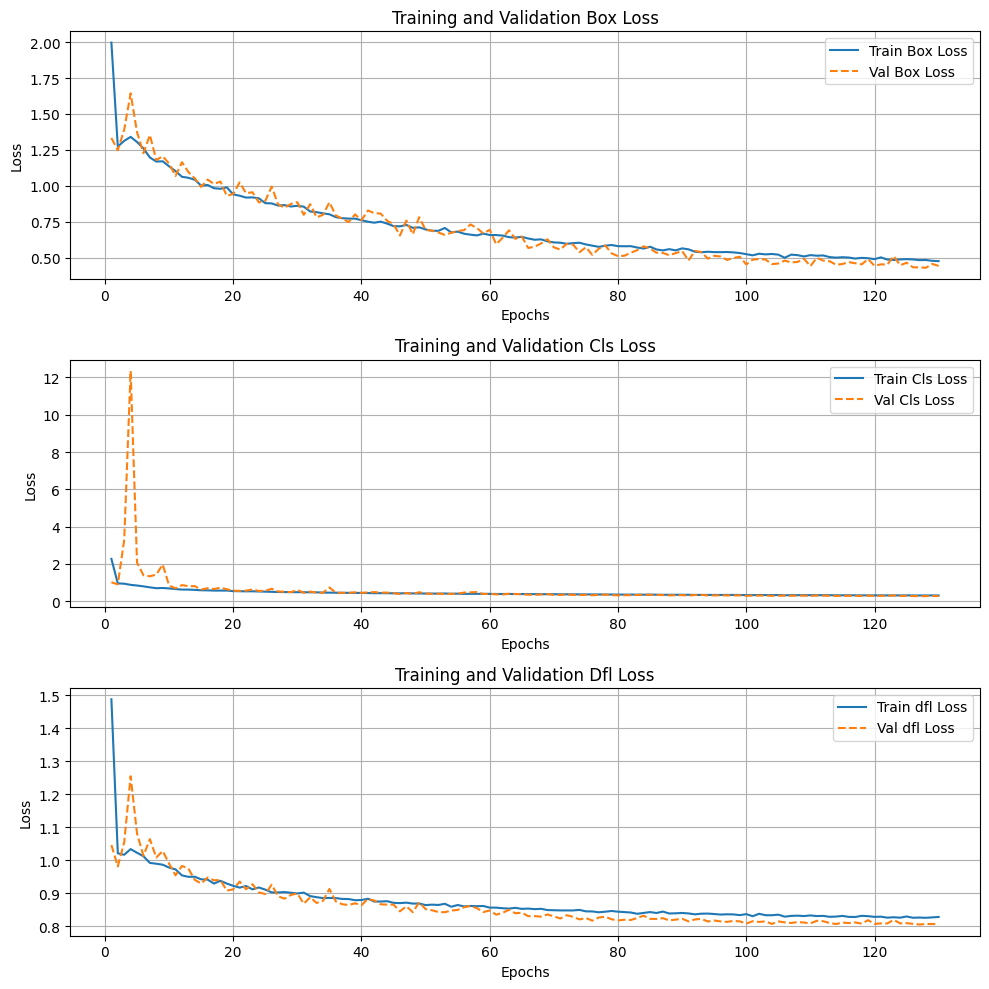

In [43]:
%matplotlib inline

fig, axs = plt.subplots(3, 1, figsize=(10,10))

axs[0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', linestyle='-')
axs[0].plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Box Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(results['epoch'], results['train/cls_loss'], label='Train Cls Loss', linestyle='-')
axs[1].plot(results['epoch'], results['val/cls_loss'], label='Val Cls Loss', linestyle='--')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Cls Loss')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(results['epoch'], results['train/dfl_loss'], label='Train dfl Loss', linestyle='-')
axs[2].plot(results['epoch'], results['val/dfl_loss'], label='Val dfl Loss', linestyle='--')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].set_title('Training and Validation Dfl Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

It can be seen that the validation Loss and the training Loss converge

#### 2. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 

In [44]:
model = YOLO('runs/detect/train/weights/best.pt')

In [45]:
test_image_path = ("datasets/images/test/" + test_df['image_name']).to_list()

df_pred = pd.DataFrame(columns=["image_name", "category", "x1_pred", "y1_pred", "x2_pred", "y2_pred", "confidence"])

for image in test_image_path:
    results = model(image)[0]  
    boxes = results.boxes  

    for box in boxes:
        x1, y1, x2, y2 = list(box.xyxy[0].tolist()) 
        conf = box.conf[0].item()  
        cls = int(box.cls[0])  

        row = pd.DataFrame([{
            "image_name": image.split("/")[-1], 
            "category": cls, 
            "x1_pred": x1, 
            "y1_pred": y1, 
            "x2_pred": x2, 
            "y2_pred": y2, 
            "confidence": conf
        }])

        df_pred = pd.concat([df_pred, row], ignore_index=True)  # Ensure indexing is reset


image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_11167_y0_7069_dxdy_416.tif: 416x416 1 0, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 158.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_7748_y0_9311_dxdy_416.tif: 416x416 5 0s, 23.9ms
Speed: 1.2ms preprocess, 23.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_2__x0_0_y0_11689_dxdy_416.tif: 416x416 29 0s, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_5899_y0_13919_dxdy_416.tif: 416x416 3 0s, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)



image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_2__x0_1055_y0_9105_dxdy_416.tif: 416x416 3 0s, 18.7ms
Speed: 1.1ms preprocess, 18.7ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_390_y0_6941_dxdy_416.tif: 416x416 12 0s, 21.3ms
Speed: 1.1ms preprocess, 21.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_8551_y0_11902_dxdy_416.tif: 416x416 3 0s, 21.3ms
Speed: 1.0ms preprocess, 21.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_6215_y0_10446_dxdy_416.tif: 416x416 3 0s, 21.1ms
Speed: 1.2ms preprocess, 21.1ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpane

In [46]:
df = pd.read_csv("data/processed_data/converted_labels.csv")
df_actual = df[df['image_name'].isin(test_df['image_name'])]
df_actual = df_actual[['image_name', 'category', 'x_pixel', 'y_pixel', 'width_pixel', 'height_pixel']]
# Convert xywh to xyxy format
x1 = df_actual['x_pixel'] - df_actual['width_pixel'] / 2
y1 = df_actual['y_pixel'] - df_actual['height_pixel'] / 2
x2 = x1 + df_actual['width_pixel']
y2 = y1 + df_actual['height_pixel']
df_actual['x1'] = x1
df_actual['y1'] = y1
df_actual['x2'] = x2
df_actual['y2'] = y2

#### 3(a) Compute mAP50 with supervision and compare with your implementation. What do you observe 


In [47]:
df_actual

,image_name,category,x_pixel,y_pixel,width_pixel,height_pixel,x1,y1,x2,y2
8,solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif,0.0,363,173,24,23,351.0,161.5,375.0,184.5
9,solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif,0.0,258,166,18,16,249.0,158.0,267.0,174.0
10,solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif,0.0,301,196,22,22,290.0,185.0,312.0,207.0
11,solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif,0.0,364,271,12,12,358.0,265.0,370.0,277.0
12,solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif,0.0,381,281,18,14,372.0,274.0,390.0,288.0
...,...,...,...,...,...,...,...,...,...,...
29527,solarpanels_native_3__x0_9847_y0_14845_dxdy_41...,0.0,204,244,30,33,189.0,227.5,219.0,260.5
29528,solarpanels_native_3__x0_9847_y0_14845_dxdy_41...,0.0,43,191,16,9,35.0,186.5,51.0,195.5
29529,solarpanels_native_3__x0_9847_y0_14845_dxdy_41...,0.0,2,130,5,7,-0.5,126.5,4.5,133.5
29579,solarpanels_native_3__x0_9930_y0_11187_dxdy_41...,0.0,151,169,13,21,144.5,158.5,157.5,179.5


In [48]:
df_pred

,image_name,category,x1_pred,y1_pred,x2_pred,y2_pred,confidence
0,solarpanels_native_3__x0_11167_y0_7069_dxdy_41...,0,227.926926,233.169525,293.269836,258.240021,0.887947
1,solarpanels_native_3__x0_7748_y0_9311_dxdy_416...,0,124.212158,225.982422,180.257996,278.246704,0.925895
2,solarpanels_native_3__x0_7748_y0_9311_dxdy_416...,0,215.076782,215.161102,246.826233,253.564148,0.923654
3,solarpanels_native_3__x0_7748_y0_9311_dxdy_416...,0,306.987671,299.666382,335.169800,324.617920,0.919160
4,solarpanels_native_3__x0_7748_y0_9311_dxdy_416...,0,379.100342,259.770447,400.684631,292.035950,0.886069
...,...,...,...,...,...,...,...
6128,solarpanels_native_3__x0_9930_y0_11187_dxdy_41...,0,144.980850,158.618851,158.686630,179.719040,0.864246
6129,solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif,0,282.774902,18.046600,372.899658,85.554169,0.939570
6130,solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif,0,217.385437,18.375488,286.730957,89.473785,0.928061
6131,solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif,0,157.493881,28.466232,200.271286,71.561272,0.915824


In [49]:
## getting our predictions and actuals in the format required for the evaluation by supervision library
predictions = []
targets = []

for image_name in df_actual["image_name"].unique():
    actual_boxes = df_actual[df_actual["image_name"] == image_name]
    gt_array = actual_boxes[["x1", "y1", "x2", "y2", "category"]].to_numpy()
    targets.append(gt_array)

    pred_boxes = df_pred[df_pred["image_name"] == image_name]
    if not pred_boxes.empty:
        pred_array = pred_boxes[["x1_pred", "y1_pred", "x2_pred", "y2_pred", "category", "confidence"]].to_numpy()
    else:
        pred_array = np.empty((0, 6))  

    predictions.append(pred_array)


In [53]:
mean_average_precison = sv.MeanAveragePrecision.from_tensors(
    predictions=predictions,
    targets=targets,
)

print(f"mAP50 calculated using supervision library : {mean_average_precison.map50}")

mAP50 calculated using supervision library : 0.9861568506491517


In [51]:
### Calculating using custom function
def compute_iou(box1, box2):
    """Compute IoU (Intersection over Union) between two bounding boxes."""
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    # Compute intersection
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Compute union
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0.0

def compute_voc11_ap(recalls, precisions):
    """Compute AP using VOC-11 method (11-point interpolation)."""
    recall_levels = np.linspace(0, 1, 11)  # [0, 0.1, ..., 1]
    max_precisions = [np.max(precisions[recalls >= r]) if np.any(recalls >= r) else 0 for r in recall_levels]
    return np.mean(max_precisions)

def compute_coco101_ap(recalls, precisions):
    """Compute AP using COCO-101 method (101-point interpolation)."""
    recall_levels = np.linspace(0, 1, 101)  # [0, 0.01, ..., 1]
    max_precisions = [np.max(precisions[recalls >= r]) if np.any(recalls >= r) else 0 for r in recall_levels]
    return np.mean(max_precisions)

def compute_auc_ap(recalls, precisions):
    """Compute AP using AUC under Precision-Recall Curve."""
    if len(recalls) < 2:
        return 0.0  # Not enough points
    return auc(recalls, precisions)

def compute_map50(predictions, targets, iou_threshold=0.5):
    """
    Compute mean Average Precision at IoU threshold 0.5 using VOC-11, COCO-101, and AUC methods.
    """
    all_voc11_aps, all_coco101_aps, all_auc_aps = [], [], []

    for pred, gt in zip(predictions, targets):
        if len(gt) == 0:
            continue  # No ground truth, skip

        pred = sorted(pred, key=lambda x: x[5], reverse=True)  # Sort by confidence score
        gt_used = set()

        tp, fp = np.zeros(len(pred)), np.zeros(len(pred))

        for i, det in enumerate(pred):
            best_iou, best_gt_idx = 0, -1

            for j, gt_box in enumerate(gt):
                if j in gt_used or gt_box[4] != det[4]:  # Skip if already matched or class mismatch
                    continue

                iou = compute_iou(det[:4], gt_box[:4])
                if iou > best_iou:
                    best_iou, best_gt_idx = iou, j

            if best_iou >= iou_threshold and best_gt_idx != -1:
                tp[i], gt_used = 1, gt_used | {best_gt_idx}
            else:
                fp[i] = 1

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        recalls = tp_cumsum / len(gt) if len(gt) > 0 else np.zeros(len(tp))
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)

        if len(recalls) > 1 and len(precisions) > 1:
            all_voc11_aps.append(compute_voc11_ap(recalls, precisions))
            all_coco101_aps.append(compute_coco101_ap(recalls, precisions))
            all_auc_aps.append(compute_auc_ap(recalls, precisions))

    # Compute mean AP for each method
    mAP_50_voc11 = np.mean(all_voc11_aps) if all_voc11_aps else 0.0
    mAP_50_coco101 = np.mean(all_coco101_aps) if all_coco101_aps else 0.0
    mAP_50_auc = np.mean(all_auc_aps) if all_auc_aps else 0.0

    return mAP_50_voc11, mAP_50_coco101, mAP_50_auc



# Compute mAP@50 using all methods
mAP_50_voc11, mAP_50_coco101, mAP_50_auc = compute_map50(predictions, targets, iou_threshold=0.5)

# Print results
print(f"mAP50 (VOC-11): {mAP_50_voc11:.4f}")
print(f"mAP50 (COCO-101): {mAP_50_coco101:.4f}")
print(f"mAP50 (AUC): {mAP_50_auc:.4f}")


mAP50 (VOC-11): 0.9666
mAP50 (COCO-101): 0.9713
mAP50 (AUC): 0.8008


Observation : The mAP50 calculated using supervision library is closest to the one calculated using COCO-101 method.

#### 3(b) Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9]

In [54]:
def calculate_metrics_from_confusion_matrix(confusion_matrix):
    """
    Calculate precision, recall, and F1 from confusion matrix
    """
    # First 3x3 contains the class predictions
    tp = np.sum(np.diag(confusion_matrix[:3, :3]))
    
    # Sum all false positives (last column excluding last row)
    fp = np.sum(confusion_matrix[:3, 3])
    
    # Sum all false negatives (last row excluding last column)
    fn = np.sum(confusion_matrix[3, :3])
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def evaluate_thresholds(predictions, targets, iou_thresholds, conf_thresholds, class_names):
    """
    Evaluate metrics across different IoU and confidence thresholds
    """
    results = {
        'precision': np.zeros((len(iou_thresholds), len(conf_thresholds))),
        'recall': np.zeros((len(iou_thresholds), len(conf_thresholds))),
        'f1': np.zeros((len(iou_thresholds), len(conf_thresholds)))
    }
    
    for i, iou_thresh in enumerate(iou_thresholds):
        for j, conf_thresh in enumerate(conf_thresholds):
            confusion_matrix = sv.ConfusionMatrix.from_tensors(
                predictions=predictions,
                targets=targets,
                classes=class_names,
                conf_threshold=conf_thresh,
                iou_threshold=iou_thresh
            )
            
            p, r, f1 = calculate_metrics_from_confusion_matrix(confusion_matrix.matrix)
            results['precision'][i, j] = p
            results['recall'][i, j] = r
            results['f1'][i, j] = f1
    
    return results

def create_threshold_tables(results, iou_thresholds, conf_thresholds):
    """
    Create formatted DataFrames for each metric
    """
    metrics = {}
    for metric_name in ['precision', 'recall', 'f1']:
        df = pd.DataFrame(
            results[metric_name],
            index=[f'IoU_{iou:.1f}' for iou in iou_thresholds],
            columns=[f'Conf_{conf:.1f}' for conf in conf_thresholds]
        )
        metrics[metric_name] = df
    
    return metrics


In [55]:
# Define thresholds
iou_thresholds = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
conf_thresholds = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
class_names = ['category_0', 'category_1', 'category_2']

# Assuming predictions and targets are your detection tensors
results = evaluate_thresholds(predictions, targets, iou_thresholds, conf_thresholds, class_names)
tables = create_threshold_tables(results, iou_thresholds, conf_thresholds)

# Print formatted tables
for metric_name, df in tables.items():
    print(f"\n{metric_name.upper()} TABLE:")
    print("=" * 50)
    print(df.round(3))
    print("\n")


PRECISION TABLE:
         Conf_0.1  Conf_0.3  Conf_0.5  Conf_0.7  Conf_0.9
IoU_0.1     0.980     0.979     0.971     0.945     0.397
IoU_0.3     0.980     0.979     0.970     0.945     0.397
IoU_0.5     0.979     0.978     0.970     0.945     0.397
IoU_0.7     0.968     0.967     0.961     0.942     0.397
IoU_0.9     0.703     0.703     0.702     0.700     0.387



RECALL TABLE:
         Conf_0.1  Conf_0.3  Conf_0.5  Conf_0.7  Conf_0.9
IoU_0.1     0.961     0.967     0.987     0.996     1.000
IoU_0.3     0.961     0.967     0.986     0.996     1.000
IoU_0.5     0.960     0.966     0.986     0.995     1.000
IoU_0.7     0.949     0.955     0.977     0.992     1.000
IoU_0.9     0.689     0.694     0.714     0.737     0.974



F1 TABLE:
         Conf_0.1  Conf_0.3  Conf_0.5  Conf_0.7  Conf_0.9
IoU_0.1     0.971     0.973     0.979     0.970     0.569
IoU_0.3     0.971     0.973     0.978     0.970     0.569
IoU_0.5     0.969     0.972     0.978     0.969     0.569
IoU_0.7     0.958     0.